# Fit NFW Density Profile

## Introduzione

Gli aloni di materia oscura sono strutture gravitazionalmente legate che svolgono un ruolo chiave nella formazione delle strutture cosmiche, agendo da nuclei gravitazionali intorno ai quali si aggrega la materia ordinaria, come gas e stelle, formando galassie e ammassidi galassie. La caratterizzazione del profilo di densità degli aloni ha molteplici applicazioni in studi cosmologici come la stima della massa di un ammasso di galassie da misure di lensing gravitazionale o lo studio delle proprietà della materia oscura.

Il profilo di densità proiettato degli aloni di materia oscura è adeguatamente descritto dal fit analitico (2D projected NFW profile):

$$ \Sigma(R, M, c, z) = 2 r_s \rho_s f(x) $$

dove $M$ è la massa dell'alone di materia oscura e $c$ la concentrazione; $r_s$ è il raggio caratteristico dell'ammasso ed è pari a:

$$ r_s = \frac{1}{c}\left(M\frac{3}{4 \pi 200 \rho_m (1+z)^3}\right)^{\frac{1}{3}} $$

dove $\rho_m$ è la densità media dell'universo approssimata a:

$$ \rho_m \simeq 0.286 \cdot 0.7^2 \cdot 2.7751428946 \cdot 10^{11} \left[\frac{\text{M}_{\odot}}{\text{Mpc}^3}\right]. $$

$\rho_s$ è la densità caratteristica dell'ammasso pari a:

$$ \begin{equation}
    \rho_s = \rho_m (1+z)^3 \delta_{char} \\
    \delta_{char} = \frac{200 c^3}{3 f_c} \\
    f_c = \text{ln}(1+c) - \frac{c}{1+c}.
\end{equation} $$

Infine $x = \frac{R}{r_s}$, con $R$ distanza dal centro dell'alone di materia oscura espressa in Mpc, e la funzione $f(x)$ è pari a:

$$ f(x) = \begin{cases}
              \frac{1}{x^2-1}\left[1-\frac{2}{\sqrt{1-x^2}}\text{arctanh}\sqrt{\frac{1-x}{1+x}}\right] &\quad \text{if}\space x<1 \\
              \frac{1}{3} &\quad \text{if}\space x=1 \\
              \frac{1}{x^2-1}\left[1-\frac{2}{\sqrt{x^2-1}}\text{arctan}\sqrt{\frac{x-1}{x+1}}\right] &\quad \text{if}\space x>1
          \end{cases} $$

## Punto a)

Implementare la funzione per calcolare $\Sigma(R, M, c, z)$ e mostrare in un grafico composto da 9 pannelli i profili di densità nell'intervallo $R \in [0.03, 1.0]$ Mpc, per le seguenti combinazioni di valori di massa e concentrazione:

$$ \begin{align}
    M& = [10^{13.5},\space 10^{14.0},\space 10^{15.0}] \space \text{M}_{\odot}; \\
    c& = [2,\space 5,\space 10]; \\
    z&= 0.0.
\end{align} $$

(Suggerimento: usare scala logaritmica per migliorare la visualizzazione).

### Implementazione

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

rho_m = 0.286 * 0.7**2 *2.7751428946e11

Per svolgere questo punto ho deciso di computare una matrice $\Sigma$ di shape (1000, 3, 3) con entrate:

$$ \Sigma_{ijk} = \Sigma(R_i, M_j, c_k, z) $$

dove $R$ è un numpyarray composto da 1000 valori compresi tra 0.03 Mpc e 1.0 Mpc equispaziati, mentre $M$ e $c$ sono a loro volta dei numpyarray contenenti i valori per i quali computare la funzione. Ho scelto questa metodologia di implementazione perché in questo modo sarà molto semplice e intuitivo graficare i risultati come richiesto.

In [2]:
M = np.array([10**13.5, 10**14.0, 10**15.0])
c = np.array([2, 5, 10])
z = 0.
R = np.linspace(0.03,1.0,1000)

Procedo computando, in ordine, $r_s$, $\rho_s$, $f(x)$ e in conclusione la matrice $\Sigma$. Per $r_s$ in particolare utilizzo il prodotto esterno implementando il metodo [np.outer](https://numpy.org/doc/stable/reference/generated/numpy.outer.html) di numpy:

In [3]:
r_s = np.outer(np.cbrt(3 * M / (4 * np.pi * 200 * rho_m * (1+z)**3)), 1/c)

In [4]:
f_c = np.log(1 + c) - c / (1 + c)
delta_char = 200 * c**3 / (3 * f_c)
rho_s = rho_m * (1+z)**3 * delta_char

Per $f(x)$ è opportuno calcolare prima $x$. In questo caso utilizzo il metodo [np.multiply.outer](https://numpy.org/doc/stable/reference/generated/numpy.ufunc.outer.html#numpy.ufunc.outer), una generalizzazione di np.outer ad array con più di una dimensione:

In [5]:
x = np.multiply.outer(R, 1/r_s)

In una prima fase, per calcolare $f(x)$ avevo utilizzato una elif ladder e una matrice della stessa shape di $x$ composta interamente di 1 così da poter utilizzare [np.less](https://numpy.org/doc/stable/reference/generated/numpy.less.html) ed [np.greater](https://numpy.org/doc/stable/reference/generated/numpy.greater.html) per controllare la condizione desiderata elemento per elemento e inserire l'opportuno valore della funzione in ciascuna entrata. Questo metodo è però poco efficiente perché richiede di calcolare 9000 volte la funzione nel contesto di 3 cicli for innestati. Una soluzione migliore è invece osservare che le funzioni che definiscono f negli intervalli $x<1$ e $x>1$ hanno domini disgiunti e utilizzare questo fatto per migliorare l'efficienza del calcolo:

In [6]:
s1 = time.time()

ones = np.ones((1000, 3, 3))

f = np.empty((1000, 3, 3))
for i in range(1000):
    for j in range(3):
        for k in range(3):
            if np.less(x, ones)[i, j, k]:
                f[i, j, k] = (1 - (2 * np.arctanh(np.sqrt((1-x[i, j, k])/(1+x[i, j, k]))) / np.sqrt(1 - x[i, j, k]**2))) / (x[i, j, k]**2 - 1)
            elif np.greater(x, ones)[i, j, k]:
                f[i, j, k] = (1 - (2 * np.arctan(np.sqrt((x[i, j, k]-1)/(1+x[i, j, k]))) / np.sqrt(x[i, j, k]**2 - 1))) / (x[i, j, k]**2 - 1)
            else: 
                f[i, j, k] = 1./3

e1 = time.time()

In [7]:
s2 = time.time()

f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)
f1[np.isnan(f1)] = 0
f2[np.isnan(f2)] = 0
f = f1 + f2
f = np.where(f == 0., 1./3, f)

e2 = time.time()

C:\Users\Ghigu\AppData\Local\Temp\ipykernel_15960\1047644650.py:3: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_15960\1047644650.py:4: RuntimeWarning: invalid value encountered in sqrt
  f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)


Si può verificare la maggiore efficienza della seconda metodologia confrontando i tempi di esecuzione:

In [8]:
print('Tempo metodo 1 =', e1-s1, 's')
print('Tempo metodo 2 =', e2-s2, 's')

Tempo metodo 1 = 0.09096002578735352 s
Tempo metodo 2 = 0.0026993751525878906 s


In conclusione, calcolo $\Sigma$:

In [9]:
Sigma = 2* rho_s * r_s * f

Come anticipato, questo approccio al problema permette di graficare i risultati ottenuti in modo semplice, iterando il comando di plot variando gli indici corrispondenti ai differenti valori di $M$ e $c$. Per rendere la rappresentazione più significativa ho inoltre fissato i valori minimi e massimi sulle ordinate per tutti e 9 i pannelli e ho impostato la scala logaritmica su entrambi gli assi per migliorare la visualizzazione, come suggerito.

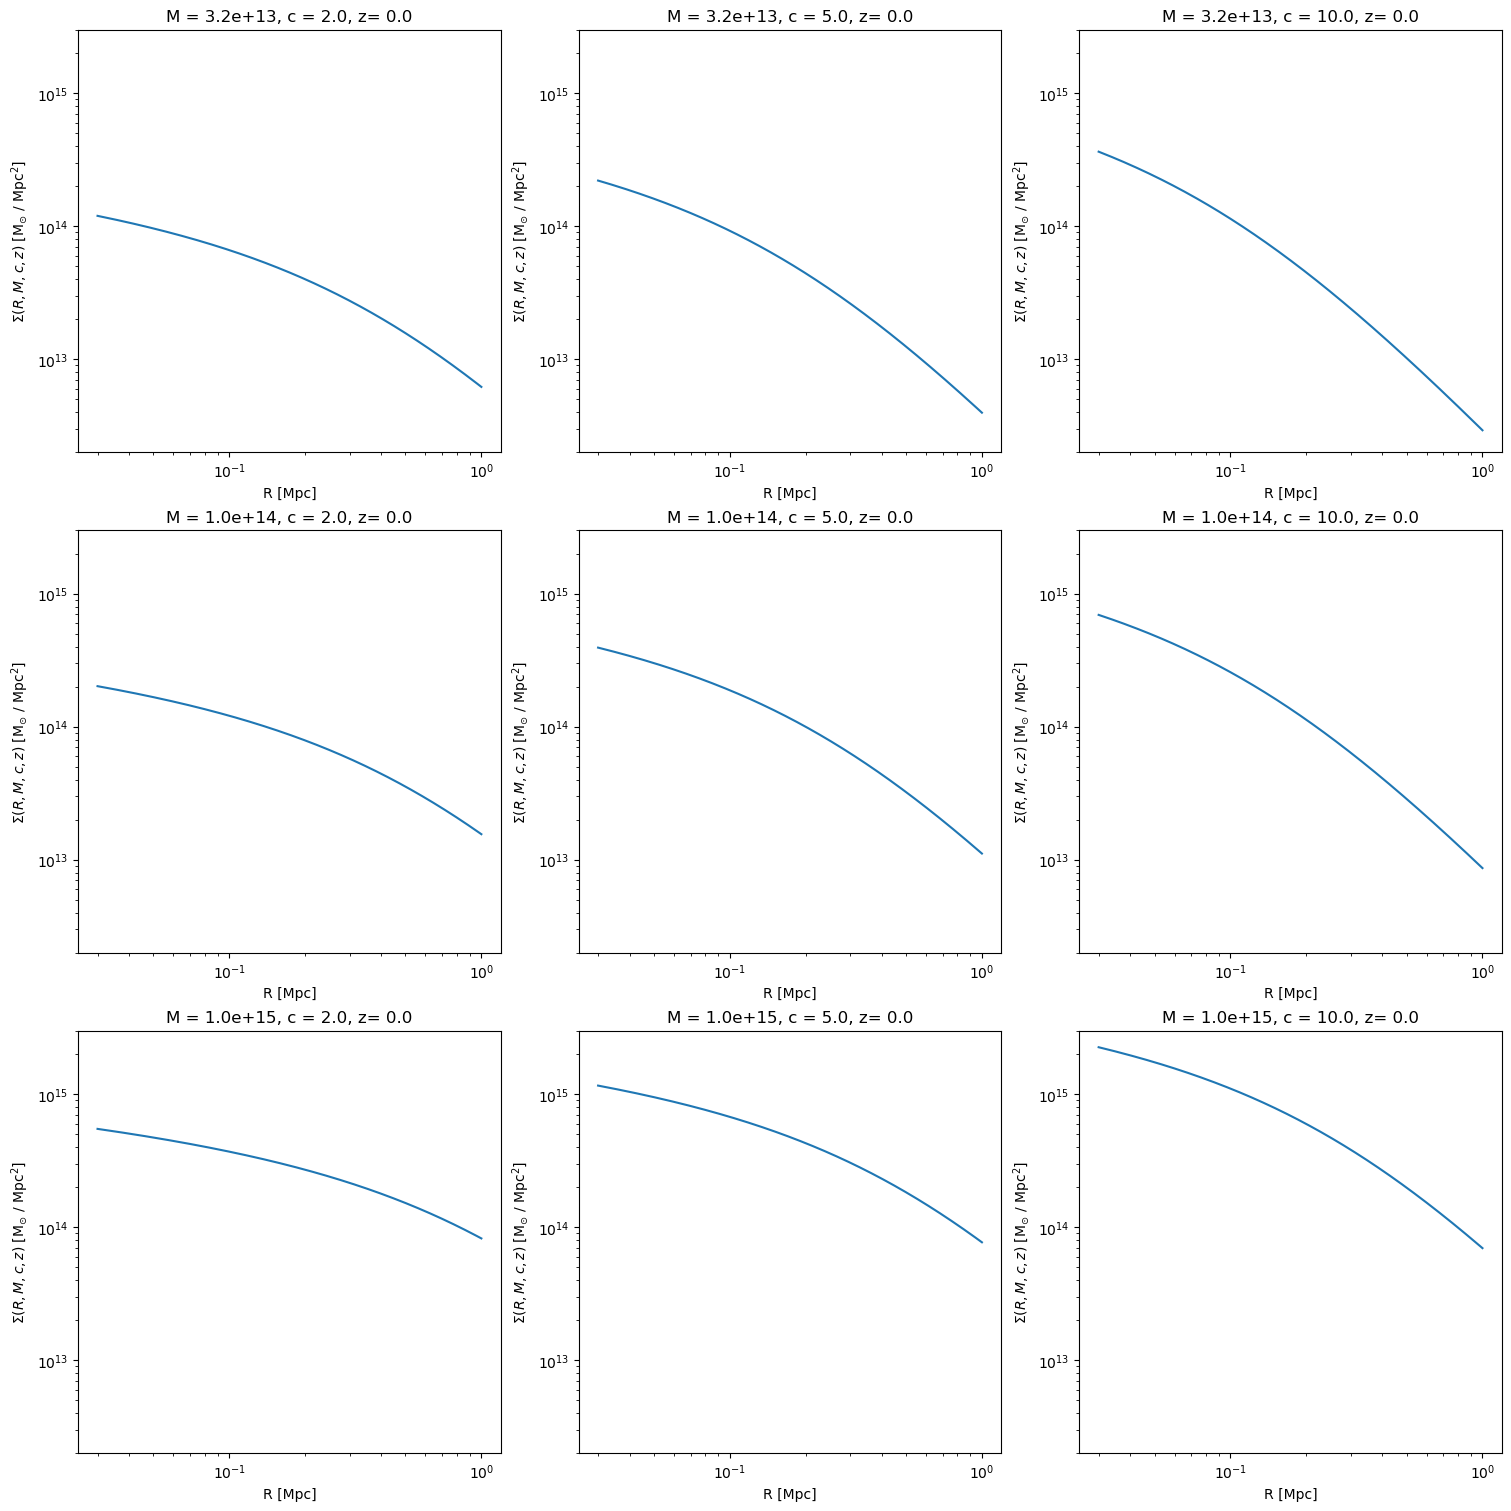

In [10]:
fig, axs = plt.subplots(3, 3, layout = 'constrained')
fig.set_size_inches(15, 15)

for j in range(3):
    for k in range(3):
        axs[j, k].plot(R, Sigma[:, j, k])
        axs[j, k].set_title('M = %.1e, c = %.1f, z= 0.0' %(M[j], c[k]))
        axs[j, k].set(xlabel = 'R [Mpc]', ylabel = r'$\Sigma(R, M, c, z)$ [M$_{\odot}$ / Mpc$^2$]',
                      xscale = 'log', yscale = 'log', ylim = [2e12, 3e15])

Dai grafici si nota come all'aumentare di $M$ e $c$ la funzione si alzi mentre al diminuire di $M$ e all'aumentare di $c$ essa diventi meno ripida.

## Punto b)

Il file `halo_catalog.fits` contiene i profili di densità di 40103 aloni di materia oscura estratti da una simulazione cosmologica N-body, il loro redshift e la ricchezza, una somma pesata del numero di galassie che popolano l'alone e che funge da proxy per la massa. I nomi delle colonne contenenti i dati sono rispettivamente: 
* redshift = 'Z',
* ricchezza = 'LAMBDA_TR',
* profilo di densità = 'SIGMA_of_R' $\left[\frac{\text{M}_{\odot}}{\text{Mpc}^2}\right]$.

I valori di $R$ in [Mpc] a cui sono calcolati i profili di densità si trovano nel file `R_values.npy`.

### Punto b1)

Suddividere il catalogo nei 5 intervalli di ricchezza aventi come estremi $\lambda = [15, 20, 30, 45, 60, 200]$ e calcolare il redshift, profilo di densità medio e la sua deviazione standard in funzione di $R$ per ognuno di questi e mostrare i risultati in un grafico con 5 pannelli.

#### Implementazione

In [11]:
from astropy.io import fits
import pandas as pd

Per maneggiare il file `.fits` ho fatto riferimento alla [guida di astropy](https://docs.astropy.org/en/stable/io/fits/index.html). In primo luogo apro il file e ricerco informazioni sulla Header Data Unit List (HDUL):

In [12]:
hdul = fits.open('halo_catalog.fits')
hdul.info()

Filename: halo_catalog.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     14   40103R x 3C   [E, E, 8E]   


Trovo che ci sono 2 HDU: Primary e una tabella. Ne deduco che i dati si trovino nell' HDU 1, procedo quindi a salvarli e a chiudere il file.

In [13]:
data = hdul[1].data
hdul.close()

La variabile data così ottenuta ha per colonne dei numpyarray. Questo mi ha permesso di rappresentare i dati in un DataFrame, scelta fatta in modo da poterli manipolare con facilità, soprattutto nell'ottica di raggrupparli per intervalli di ricchezza. Per farlo ho inizialmente creato un DataFrame che contenesse solo le entrate della colonna 'SIGMA_R', questo perché nel file `halo_catalog.fits` tale colonna contiene in realtà un numpyarray a 2 dimensioni e per poter convertire la tabella in Pandas avevo bisogno di "spacchettare" quella colonna in più colonne.

In [14]:
SigR = data['SIGMA_of_R'].newbyteorder().byteswap()
df1 = pd.DataFrame(SigR, columns = ['SIGMA_of_R0', 'SIGMA_of_R1', 'SIGMA_of_R2', 'SIGMA_of_R3', 'SIGMA_of_R4', 
                                    'SIGMA_of_R5', 'SIGMA_of_R6', 'SIGMA_of_R7'])

Come si può vedere, oltre a quanto anticipato, ho applicato il metodo [numpy.newbyteorder().byteswap()](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.byteswap.html). In una prima versione del codice non ero stato così accorto e più avanti nell'implementazione (in particolare nell'atto di effettuare il groupby per intervalli di ricchezza), sono incorso nell'errore:

"Big-endian buffer not supported on little-endian compiler"

Questo perché Pandas funziona correttamente solo se i dati salvati nel DataFrame o nella Serie in oggetto sono in native byte order, cioè little-endian (quantomeno nel caso di sistemi Linux o Windows). Al contrario nei file `.fits` i dati immagazzinati sono big-endian e questo causa un problema di compatibilità che necessita di essere risolto [invertendo l'endianess dei dati in input](https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html#byte-ordering-issues).

Dopo questo accorgimento, sono passato a creare un secondo DataFrame, contenente questa volta i dati relativi alle prime due colonne della tabella e dunque le ho concatenate per creare il DataFrame bersaglio.

In [15]:
data_dict = {'Z': data['Z'].newbyteorder().byteswap(), 'LAMBDA_TR': data['LAMBDA_TR'].newbyteorder().byteswap()}
df2 = pd.DataFrame(data_dict)
df = pd.concat([df2, df1], axis = 1)
df

,Z,LAMBDA_TR,SIGMA_of_R0,SIGMA_of_R1,SIGMA_of_R2,SIGMA_of_R3,SIGMA_of_R4,SIGMA_of_R5,SIGMA_of_R6,SIGMA_of_R7
0,0.502494,290.692261,2.351102e+15,1.992653e+15,1.496068e+15,1.186635e+15,8.963382e+14,6.253857e+14,3.943133e+14,2.285814e+14
1,0.601302,119.245781,2.107659e+15,1.980064e+15,1.652226e+15,1.229586e+15,9.864418e+14,7.124628e+14,4.493736e+14,2.624644e+14
2,0.208961,126.373863,1.814137e+15,1.739587e+15,1.344639e+15,1.121889e+15,8.703220e+14,5.941933e+14,3.668202e+14,1.864975e+14
3,0.212769,188.812729,2.349731e+15,1.945845e+15,1.539410e+15,1.077038e+15,7.059310e+14,4.613497e+14,2.969404e+14,1.913648e+14
4,0.458008,147.349625,2.240655e+15,1.679705e+15,1.314239e+15,1.120241e+15,8.280310e+14,5.703857e+14,3.796933e+14,2.315893e+14
...,...,...,...,...,...,...,...,...,...,...
40098,0.479437,9.510518,7.317734e+14,7.352522e+14,5.704476e+14,3.042415e+14,1.612240e+14,9.388085e+13,6.723513e+13,6.424537e+13
40099,0.599918,17.036392,5.234640e+14,4.248873e+14,3.092860e+14,2.059087e+14,1.372936e+14,8.645296e+13,4.359242e+13,2.579911e+13
40100,0.622782,8.831167,6.419276e+14,4.426898e+14,3.834843e+14,2.781025e+14,1.816492e+14,1.097785e+14,7.185037e+13,5.326193e+13
40101,0.535050,12.180819,3.163261e+14,3.317815e+14,2.491461e+14,1.719007e+14,1.450824e+14,1.283064e+14,8.723127e+13,5.760639e+13


DA FINIRE

In [16]:
int_mean = df.groupby(pd.cut(df['LAMBDA_TR'], [15, 20, 30, 45, 60, 200])).mean()
int_mean

,Z,LAMBDA_TR,SIGMA_of_R0,SIGMA_of_R1,SIGMA_of_R2,SIGMA_of_R3,SIGMA_of_R4,SIGMA_of_R5,SIGMA_of_R6,SIGMA_of_R7
LAMBDA_TR,,,,,,,,,,
"(15, 20]",0.460090,17.523481,6.040370e+14,4.900458e+14,3.598957e+14,2.441868e+14,1.573150e+14,9.940772e+13,6.326566e+13,4.258762e+13
"(20, 30]",0.463887,24.182133,6.717476e+14,5.498711e+14,4.078379e+14,2.780886e+14,1.798401e+14,1.131488e+14,7.073311e+13,4.623129e+13
"(30, 45]",0.459208,35.880253,8.322382e+14,6.875067e+14,5.164361e+14,3.578354e+14,2.345928e+14,1.480616e+14,9.084872e+13,5.603594e+13
"(45, 60]",0.456439,51.205067,1.017487e+15,8.481862e+14,6.493962e+14,4.575311e+14,3.030807e+14,1.918116e+14,1.166462e+14,6.985587e+13
"(60, 200]",0.441161,78.995392,1.299284e+15,1.092726e+15,8.503404e+14,6.101899e+14,4.143562e+14,2.673323e+14,1.639046e+14,9.581197e+13


In [17]:
#R_int_mean = int_mean.loc[:, ['SIGMA_of_R0', 'SIGMA_of_R1', 'SIGMA_of_R2', 'SIGMA_of_R3', 'SIGMA_of_R4', 'SIGMA_of_R5', 'SIGMA_of_R6', 'SIGMA_of_R7']]
R_int_mean = int_mean.loc[:, [R[0], R[1], R[2], R[3], R[4], R[5], R[6], R[7]]]
R_int_mean

KeyError: "None of [Index([                0.03,  0.03097097097097097,  0.03194194194194194,\n       0.032912912912912914, 0.033883883883883886,  0.03485485485485485,\n        0.03582582582582582, 0.036796796796796795],\n      dtype='float64')] are in the [columns]"

In [ ]:
np.shape(R_int_mean.T.to_numpy())

In [ ]:
int_std = df.groupby(pd.cut(df['LAMBDA_TR'], [15, 20, 30, 45, 60, 200])).std()
int_std

In [ ]:
#R_int_std = int_std.loc[:, ['SIGMA_of_R0', 'SIGMA_of_R1', 'SIGMA_of_R2', 'SIGMA_of_R3', 'SIGMA_of_R4', 'SIGMA_of_R5', 'SIGMA_of_R6', 'SIGMA_of_R7']]
R_int_std = int_std.loc[:, [R[0], R[1], R[2], R[3], R[4], R[5], R[6], R[7]]]
R_int_std


In [ ]:
R = np.load('R_values.npy')

fig, axs = plt.subplots(5, layout = 'constrained')
fig.set_size_inches(15, 15)

axs[0].plot(R, R_int_mean.T.to_numpy()[:,0], label = 'Mean')
axs[0].set_title('LAMBDA_TR in (15,20]')
axs[0].plot(R, R_int_std.T.to_numpy()[:,0], color = 'tab:orange', label = 'Std')
axs[0].legend(fontsize = 'x-large')
axs[1].plot(R, R_int_mean.T.to_numpy()[:,1], label = 'Mean')
axs[1].set_title('LAMBDA_TR in (20,30]')
axs[1].plot(R, R_int_std.T.to_numpy()[:,1], color = 'tab:orange', label = 'Std')
axs[2].plot(R, R_int_mean.T.to_numpy()[:,2], label = 'Mean')
axs[2].set_title('LAMBDA_TR in (30,45]')
axs[2].plot(R, R_int_std.T.to_numpy()[:,2], color = 'tab:orange', label = 'Std')
axs[3].plot(R, R_int_mean.T.to_numpy()[:,3], label = 'Mean')
axs[3].set_title('LAMBDA_TR in (45,60]')
axs[3].plot(R, R_int_std.T.to_numpy()[:,3], color = 'tab:orange', label = 'Std')
axs[4].plot(R, R_int_mean.T.to_numpy()[:,4], label = 'Mean')
axs[4].set_title('LAMBDA_TR in (60,200]')
axs[4].plot(R, R_int_std.T.to_numpy()[:,4], color = 'tab:orange', label = 'Std')

for ax in axs.flat:
    ax.set(xlabel = 'R [Mpc]', ylabel = 'Sigma (R, M, c, z) [M_sol / Mpc**2]', xscale = 'log', yscale = 'log', ylim = [1e13, 2e15])
    ax.legend(fontsize = 'x-large')

Per prima cosa riporto i comandi che ho utilizzato per installare [emcee](https://emcee.readthedocs.io/en/stable/user/install/) e [pygtc](https://pygtc.readthedocs.io/en/latest/installation.html).

In [ ]:
#!python -m pip install -U pip
#!pip install -U setuptools setuptools_scm pep517
#!pip install -U emcee
#!pip install pygtc

In [ ]:
import emcee
from scipy.optimize import minimize
import pygtc

I parametri che devo inferire sono Log(M) e c.
Devo assumere una likelihood gaussiana, con matrici di covarianza date da Sigma-cov.npy.
Devo utilizzare la Sigma.
I prior sono Log(M) tra 13 e 16, c tra 0.2 e 20.
Lo devo fare per ogni bin di ricchezza e devo utilizzare il relativo redshift medio.

In [ ]:
CovMat = np.load('covariance_matrices.npy')
rho_m = 0.286 * 0.7**2 *2.7751428946e11

R = np.load('R_values.npy')
Sigma_R = R_int_mean.to_numpy()
z_int_mean = int_mean.loc[:, ['Z']]
z = np.squeeze(z_int_mean.to_numpy())
Sigma_R[0], z[0].shape

Nota: Ho dovuto usare np.squeeze perché il redshift veniva passato come array (5,1) invece che come array (5,), questo dava problemi con il minimize dato che tutte le funzioni che ricevevano z[i] come input non restituivano un float come output, ma un array (1,) con cui minimize non sapeva lavorare.

In [ ]:
def r_s(lM, c, rdsft_i):
    return np.cbrt(3 * 10**lM / (4 * np.pi * 200 * rho_m * (1 + rdsft_i)**3)) / c

def rho_s(c, rdsft_i):
    f_c = np.log(1 + c) - c / (1 + c)
    delta_char = 200 * c**3 / (3 * f_c)
    return rho_m * (1 + rdsft_i)**3 * delta_char
    
def f(x):
    f = np.empty(8)
    for j in range(8):
        if np.less(x, np.ones(8))[j]:
            f[j] = (1 - (2 * np.arctanh(np.sqrt((1-x[j])/(1+x[j]))) / np.sqrt(1 - x[j]**2))) / (x[j]**2 - 1)
        elif np.greater(x, np.ones(8))[j]:
            f[j] = (1 - (2 * np.arctan(np.sqrt((x[j]-1)/(1+x[j]))) / np.sqrt(x[j]**2 - 1))) / (x[j]**2 - 1)
        else: 
            f[j] = 1./3
    return f

def Sigma(Rad, lM, c, rdsft_i):
    x = Rad / r_s(lM, c, rdsft_i)
    return 2 * r_s(lM, c, rdsft_i) * rho_s(c, rdsft_i) * f(x)

In [ ]:
def log_prior(param):
    lM, c = param
    if (13 < lM < 16 and 0.2 < c < 20):
        return 0.0
    return -np.inf

def log_likelihood(param, Denprof, Rad, rdsft, TCOV):
    lM, c = param
    
    th_Sigma = Sigma(Rad, lM, c, rdsft)
    
    iTCOV = np.linalg.inv(TCOV)
    
    residuals = (Denprof - th_Sigma).T
    
    p, _ = TCOV.shape
    lognormalization = - 0.5 * (p * np.log(2 * np.pi) + np.log(np.linalg.det(TCOV)))
    exponent = -0.5 * np.sum(residuals @ iTCOV * residuals)
    return np.nansum(lognormalization + exponent)

def log_posterior(param, Denprof, Rad, rdsft, TCOV):
    lp = -log_prior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(param, Denprof, Rad, rdsft, TCOV)

In [ ]:
lM = 14.53
c = 10.09

param = [lM, c]
lint, _, _ = CovMat.shape
for k in range(lint):
    print(log_likelihood(param, Sigma_R[k], R, z[k], CovMat[k]))

In [ ]:
nll = lambda *args: -log_posterior(*args)
initial = np.array([13 + 3 * np.random.rand(), 0.2 + 19.8 * np.random.rand()]) 
soln0 = minimize(nll, initial, args = (Sigma_R[0], R, z[0], CovMat[0]))
soln = [soln0, soln0, soln0, soln0, soln0]
print(initial, soln0.x, log_likelihood(soln0.x, Sigma_R[0], R, z[0], CovMat[0]))
for k in range(lint - 1):
    soln[k + 1] = minimize(nll, initial, args = (Sigma_R[k + 1], R, z[k + 1], CovMat[k + 1]))
    print(initial, soln[k + 1].x, log_likelihood(soln[k + 1].x, Sigma_R[k + 1], R, z[k + 1], CovMat[k + 1]))

In [ ]:
residui = (Sigma_R[0] - Sigma(R, soln0.x[0], soln0.x[1], z[0])).T
np.sum(residui @ np.linalg.inv(CovMat[0]) * residui)
#np.nansum(-0.5 * np.sum(residui @ np.linalg.inv(CovMat[0]) * residui) + (- 0.5 * (8 * np.log(2 * np.pi) + np.log(np.linalg.det(CovMat[0])))))

In [ ]:
nparams = len(param)

pos = soln[0].x * (1+1e-4 * np.random.randn(32,nparams ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args = (Sigma_R[0], R, z[0], CovMat[0])
)
sampler.run_mcmc(pos, 2000, progress=True);

In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
print(sampler.get_autocorr_time())

In [ ]:
flat_samples = sampler.get_chain(discard = 100, flat = True)
flat_samples.shape

In [ ]:
bf_lM = np.median(flat_samples[:, 0])
bf_c = np.median(flat_samples[:, 1])

print('Best-fit log_10(M) =', bf_lM)
print('Best-fit c =', bf_c)
print('Mean log_10(M) =', flat_samples[:,0].mean())
print('Mean c =', flat_samples[:,1].mean())
print('std log_10(M) =', flat_samples[:,0].std())
print('std c =', flat_samples[:,1].std())

In [ ]:
bf_param = [bf_lM, bf_c]
log_likelihood(bf_param, Sigma_R[0], R, z[0], CovMat[0])

In [ ]:
x_i = Sigma_R[0]
mu_i = Sigma(R, bf_lM, bf_c, z[0])
#mu_i = Sigma(R, soln0.x[0], soln0.x[1], z[0])
var_i = np.empty(8)

for i in range(8):
    var_i[i] = CovMat[0, i, i]

t = np.sum((x_i - mu_i)**2 / var_i)
t

In [ ]:
from scipy.stats import chi2

rdn_values = np.empty([100, 2])
for i in range(2):
    for j in range(100):
        rdn_values[j, i] = flat_samples[np.random.randint(0, flat_samples.shape[0]), i]

t_rdn = np.empty(100)        

for j in range(100):
    mu_i = Sigma(R, rdn_values[j, 0], rdn_values[j, 1], z[0])
    t_rdn[j] = np.sum((x_i - mu_i)**2 / var_i)
    
print(t_rdn)

fig, ax = plt.subplots(1, layout = 'constrained')
fig.set_size_inches(5,5)

ax.hist(t_rdn, bins = 'sturges', density = 'True')

In [ ]:
fig, axs = plt.subplots(5, layout = 'constrained')
fig.set_size_inches(15, 15)

axs[0].scatter(R, R_int_mean.T.to_numpy()[:,0], label = 'Mean')
axs[0].set_title('LAMBDA_TR in (15,20]')
axs[0].plot(R, Sigma(R, rdn_values[99, 0], rdn_values[99, 1], z[0]), color = 'tab:orange', label = 'fit')
axs[0].errorbar(R, R_int_mean.T.to_numpy()[:,0], np.sqrt(var_i), fmt='none')
axs[0].legend(fontsize = 'x-large')

for ax in axs.flat:
    ax.set(xlabel = 'R [Mpc]', ylabel = 'Sigma (R, M, c, z) [M_sol / Mpc**2]', xscale = 'log', yscale = 'log', ylim = [1e13, 2e15])
    ax.legend(fontsize = 'x-large')

In [ ]:
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=['$log_{10}(M)$','$c$'],
                    figureSize='MNRAS_page')

Voglio che bf_Sigma sia una matrice in cui nelle righe vario il valore di z e nelle colonne quello di R. (Matrice 40103x8)

In [ ]:
df_15 = df[15 < df['LAMBDA_TR']]
df_1520 = df_15[20 >= df_15['LAMBDA_TR']]

df_20 = df[20 < df['LAMBDA_TR']]
df_2030 = df_15[30 >= df_15['LAMBDA_TR']]

df_30 = df[30 < df['LAMBDA_TR']]
df_3045 = df_15[45 >= df_15['LAMBDA_TR']]

df_45 = df[45 < df['LAMBDA_TR']]
df_4560 = df_15[60 >= df_15['LAMBDA_TR']]

df_60 = df[60 < df['LAMBDA_TR']]
df_60200 = df_15[200 >= df_15['LAMBDA_TR']]

df_1520

In [ ]:
rho_m = 0.286 * 0.7**2 *2.7751428946e11
z_data_1520 = df_1520['Z'].to_numpy()
z_data_1520.shape

In [ ]:
def Sigma_1(Rad, lM, conc, rdsft):
    M = 10**lM
    
    r_s = np.cbrt(3 * M / (4 * np.pi * 200 * rho_m * (1 + rdsft)**3)) / conc
    
    f_c = np.log(1 + conc) - conc / (1 + conc)
    delta_char = 200 * conc**3 / (3 * f_c)
    rho_s = rho_m * (1 + rdsft)**3 * delta_char
    
    x = np.multiply.outer(1/r_s, Rad)

    f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
    f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)
    f1[np.isnan(f1)] = 0
    f2[np.isnan(f2)] = 0
    f = f1 + f2
    f = np.where(f == 0., 1./3, f)
    
    Sigma = np.empty([rdsft.shape[0], 8])
    for i in range(8):
        Sigma[:, i] = 2* rho_s * r_s * f[:,0]
        
    return Sigma

Sigma_1(R, bf_lM, bf_c, z_data_1520).shape

In [ ]:
nparams = len(param)

pos = soln[1].x * (1+1e-4 * np.random.randn(32,nparams ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args = (Sigma_R[1], R, z[1], CovMat[1])
)
sampler.run_mcmc(pos, 2000, progress=True);

In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
nparams = len(param)

pos = soln[2].x * (1+1e-4 * np.random.randn(32,nparams ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args = (Sigma_R[2], R, z[2], CovMat[2])
)
sampler.run_mcmc(pos, 2000, progress=True);

In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
nparams = len(param)

pos = soln[3].x * (1+1e-4 * np.random.randn(32,nparams ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args = (Sigma_R[3], R, z[3], CovMat[3])
)
sampler.run_mcmc(pos, 2000, progress=True);

In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
nparams = len(param)

pos = soln[4].x * (1+1e-4 * np.random.randn(32,nparams ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args = (Sigma_R[4], R, z[4], CovMat[4])
)
sampler.run_mcmc(pos, 2000, progress=True);

In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");